# Dense Model for Kinect data

We've trained a classifier from Keras Sequential class with Dense layers to categorize good and bad exercises from Kinect data. This data was preprocessed according to the Notebook **data_preparation_problemA_kinect.ipynb**.

## Section for Configurations and Imports

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
random_state = 47
np.random.seed(random_state)

In [5]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## 1. Load Prepared Dataset

In [6]:
file_path = 'https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/all_good_bad_problemB_posenet/'

df = pd.read_csv(file_path + 'good_bad_posenet_1.csv')

for i in range(2, 5):
  try:
    file_name = 'good_bad_posenet_{}.csv'.format(i)
    temp = pd.read_csv(file_path + file_name)
    df = df.append(temp, ignore_index=True)
  except IOError as e:
    print('Could not find file: ', file_name)

df.fillna(0, inplace=True) # Replace NaN with 0

df.shape

(569384, 27)

## 2. Split into sets for training, validation, and testing + use and save scaler

In [7]:
X = df.drop(columns=['quality'])
y = df['quality']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (409956, 26)
Training labels shape: (409956,) 

Validation features shape: (102489, 26)
Validation labels shape: (102489,) 

Test features shape: (56939, 26)
Test labels shape: (56939,) 



## 3. Define the Model

The model will be created using the make_model function that uses a Layer Factory so we can experiment with different layer configurations.

We're using standard evaluation metrics for binary classification problems to evaulate model performance.

### 3.1 Layer factory

In [10]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        return Dropout(rate=nodes)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

### 3.2 Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(layers, input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    for layer in layers:
        model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 4. MLflow Experimentation

### 4.1 Configurations

In [12]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "left_wrist_x"),
    ColSpec("double", "left_wrist_y"),
    ColSpec("double", "right_wrist_x"),
    ColSpec("double", "right_wrist_y"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "left_ankle_x"),
    ColSpec("double", "left_ankle_y"),
    ColSpec("double", "right_ankle_x"),
    ColSpec("double", "right_ankle_y")
])
output_schema = Schema([
    ColSpec("boolean", "quality")
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

### 4.2 Helper functions

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

### 4.3 Configurations

In [14]:
EPOCHS = 500
BATCH_SIZE = 150

input_dim = X_train.shape[1]
output_size = 1

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
optimizer = 'Adam'
learning_rate = 1e-3

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation, 'kernel_initializer': kernel_initializer },
    { 'type': 'Dense', 'nodes':58, 'activation': activation },
    { 'type': 'Dense', 'nodes':32, 'activation': 'tanh' },
    { 'type': 'Dense', 'nodes':units, 'activation': activation, 'kernel_initializer': 'random_normal'  },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

### 4.4 Start Run

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 58)                3770      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1888      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,563
Trainable params: 9,563
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
2734/2734 [==============================] - 20s 7ms/step - loss: 0.4230 - tp: 277986.0000 - fp: 64366.

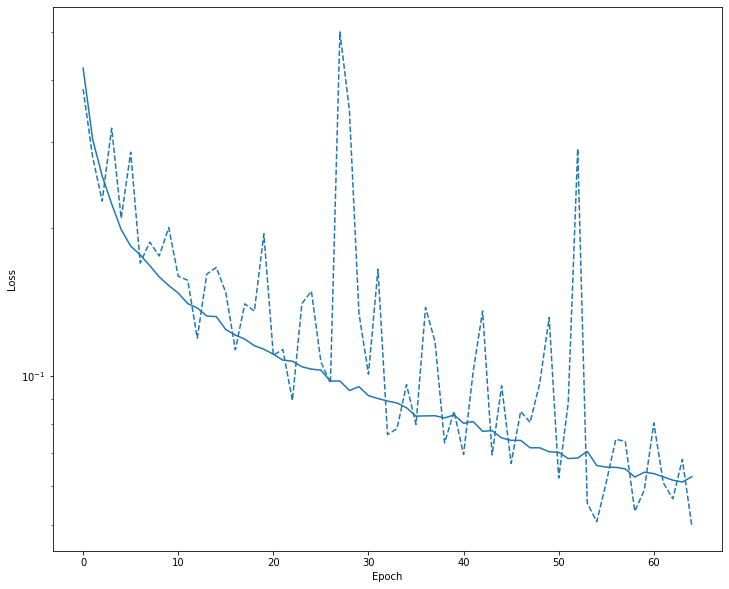

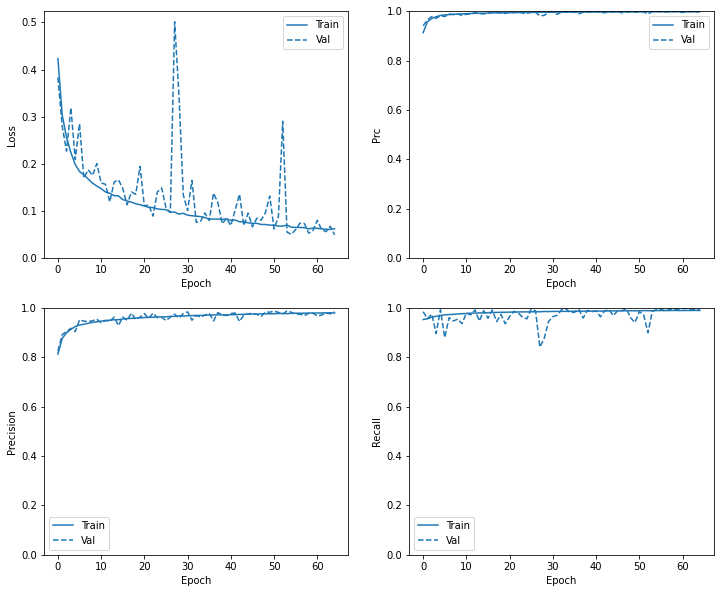

loss :  0.05240902304649353 /n
tp :  40237.0 /n
fp :  775.0 /n
tn :  15584.0 /n
fn :  343.0 /n
accuracy :  0.980364978313446 /n
precision :  0.9811030626296997 /n
recall :  0.9915475845336914 /n
auc :  0.9973289966583252 /n
prc :  0.9986373782157898 /n
True Negatives:  15584
False Positives:  775
False Negatives:  343
True Positives:  40237
Total:  40580


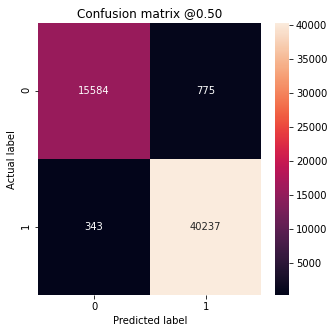

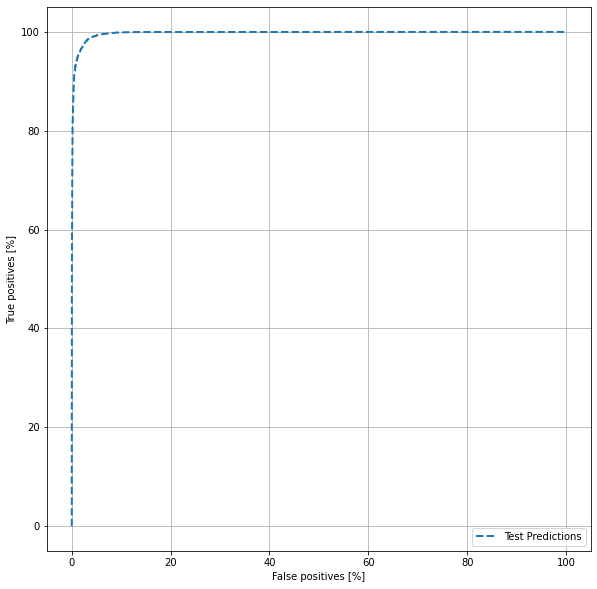

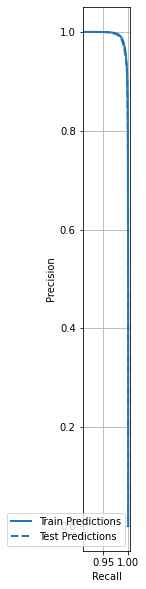

INFO:tensorflow:Assets written to: C:\Users\angel\AppData\Local\Temp\tmprcjmmoab\model\data\model\assets


In [15]:
model_name = 'dense_model_posenet_good/bad'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        layers=LAYERS, 
                        loss='binary_crossentropy', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        input_dim=input_dim)
    
    with tf.device('/CPU:0'):
        history = model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

        # Plot training history
        plot_loss(history, "Bias", 0)
        plt.savefig("loss.jpg")
        mlflow.log_artifact("loss.jpg")
        plt.show()
        
        # Plot and log metrics
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        plot_metrics(history)
        plt.savefig("metrics.jpg")
        mlflow.log_artifact("metrics.jpg")
        plt.show()

        # Confusion matrix
        results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
        for name, value in zip(model.metrics_names, results):
            print(name, ': ', value, '/n')
        plot_cm(y_test, predictions_test)
        plt.savefig("cm.jpg")
        mlflow.log_artifact("cm.jpg")
        plt.show()

        # ROC Curve
        plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
        plt.legend(loc='lower right')
        plt.savefig("roc.jpg")
        mlflow.log_artifact("roc.jpg")
        plt.show()

        # Precision-Recall Curve (PRC)
        plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
        plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
        plt.legend(loc='lower right')
        plt.savefig("prc.jpg")
        mlflow.log_artifact("prc.jpg")
        plt.show()
        
        # Log model, scaler, model parameters to MLflow
        mlflow.log_param("units", units)
        mlflow.log_param("activation", activation)
        mlflow.log_param("kernel_initializer", kernel_initializer)
        mlflow.log_param("output activation", output_activation)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("learning rate", learning_rate)
        mlflow.log_param("batch size", BATCH_SIZE)
        mlflow.log_param("epochs", early_stopping.stopped_epoch)
        mlflow.log_metric("accuracy", results[5])
        mlflow.log_metric("average precision score", results[6])
        mlflow.log_metric("recall", results[7])
        mlflow.log_metric("auc", results[8])

        mlflow.keras.log_model(model, model_name, signature=signature)
        mlflow.sklearn.log_model(scaler, 'InputScaler')

## 5. Register Model

In [16]:
model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
mv = mlflow.register_model(model_uri, model_name)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Successfully registered model 'dense_model_posenet_good/bad'.
2021/05/18 13:38:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dense_model_posenet_good/bad, version 1
Name: dense_model_posenet_good/bad
Version: 1
Created version '1' of model 'dense_model_posenet_good/bad'.
